# Algoritmos de Classificação: Regressão Logística

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, log_loss)

from plotting import (multiple_histograms_plot, bar_plot_with_categorical, 
                      plot_confusion_matrix, plot_roc)

In [2]:
sns.set_context("notebook", font_scale=1.5)

In [3]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Exploratory Data Analysis (EDA)

In [4]:
df.shape

(9280, 10)

In [5]:
df.dtypes

duration_seconds      int64
duration_minutes    float64
duration_hours      float64
emp.var.rate        float64
nr.employed         float64
euribor3m           float64
month                object
contact               int64
loan                  int64
subscribed             bool
dtype: object

In [6]:
df.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,month,contact,loan,subscribed
0,1575,26.250000,0.437500,1.1,5191.0,4.857,may,1,0,True
1,1042,17.366667,0.289444,1.1,5191.0,4.857,may,1,0,True
2,1467,24.450000,0.407500,1.1,5191.0,4.857,may,1,0,True
3,579,9.650000,0.160833,1.1,5191.0,4.857,may,1,0,True
4,461,7.683333,0.128056,1.1,5191.0,4.857,may,1,0,True


In [7]:
null_count = df.isnull().sum().sort_values(ascending=False)
null_percentage = null_count / len(df)
pd.DataFrame(data=[null_count, null_percentage],
             index=['null_amount', 'null_ratio']).T

,null_amount,null_ratio
subscribed,0.0,0.0
loan,0.0,0.0
contact,0.0,0.0
month,0.0,0.0
euribor3m,0.0,0.0
nr.employed,0.0,0.0
emp.var.rate,0.0,0.0
duration_hours,0.0,0.0
duration_minutes,0.0,0.0
duration_seconds,0.0,0.0


In [8]:
no_duration = df['duration_seconds'] == 0
print(f'calls with no duration: {no_duration.sum()}')

calls with no duration: 0


In [9]:
subscribed_mask = df['subscribed'] == True
subscription_rate = (subscribed_mask).sum() / (subscribed_mask.sum() + (~subscribed_mask).sum())
print(f'subscription_rate: {subscription_rate}')

subscription_rate: 0.5


### duration_seconds

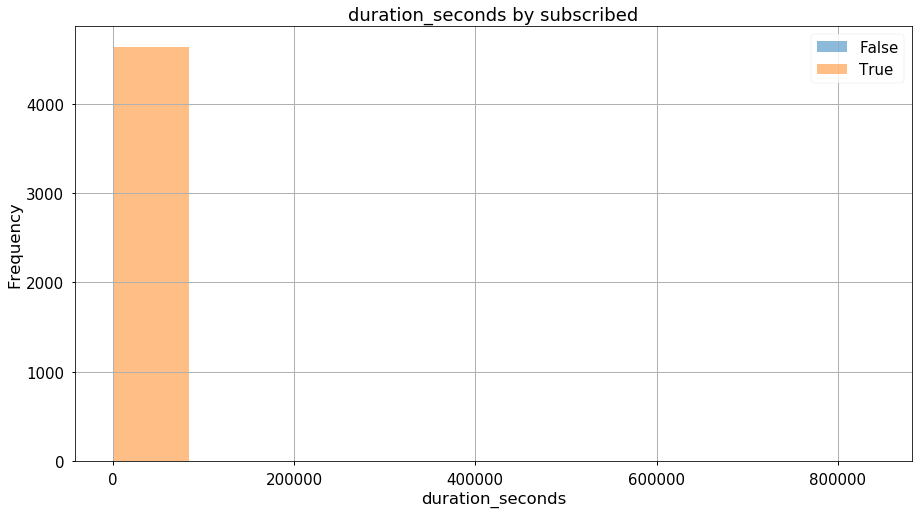

In [10]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed')

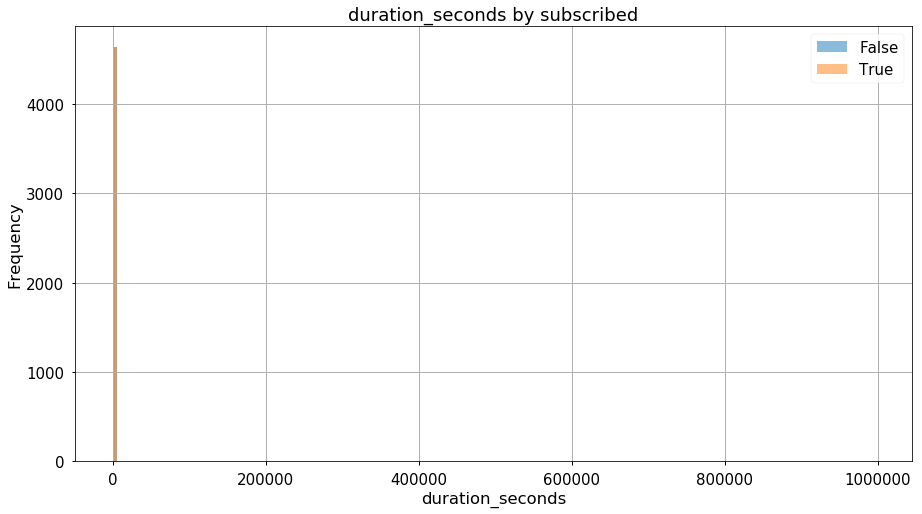

In [11]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 1_000_000, 5_000))

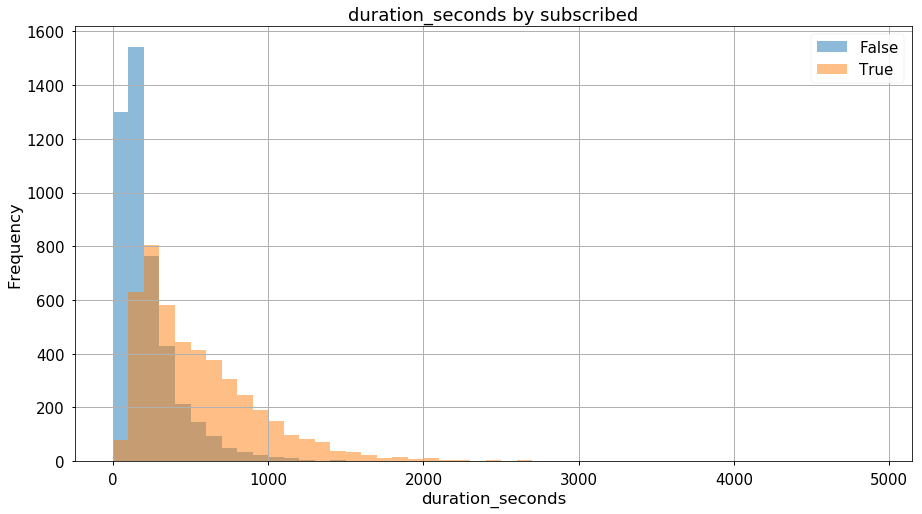

In [12]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 5_000, 100))

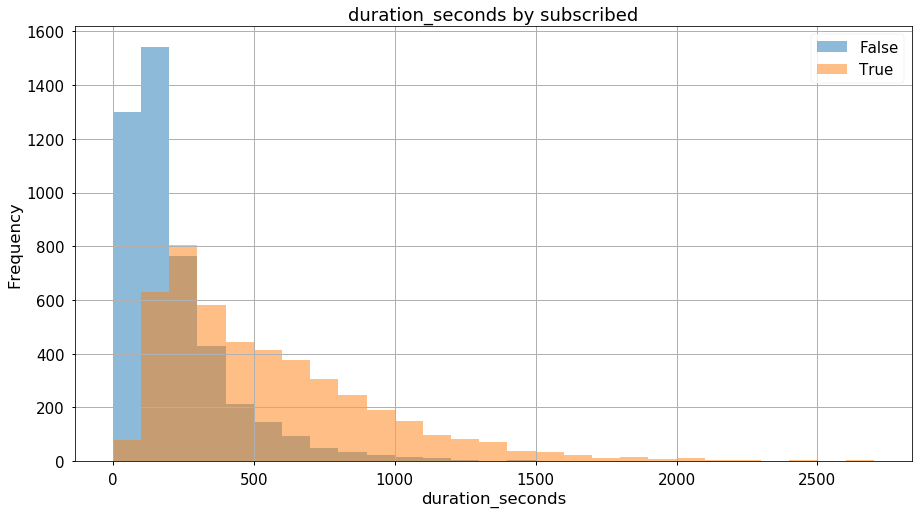

In [13]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 2_800, 100))

In [14]:
np.log10(df['duration_seconds'].max())

5.9241758703019212

min = 6.3s
max = 1000000s


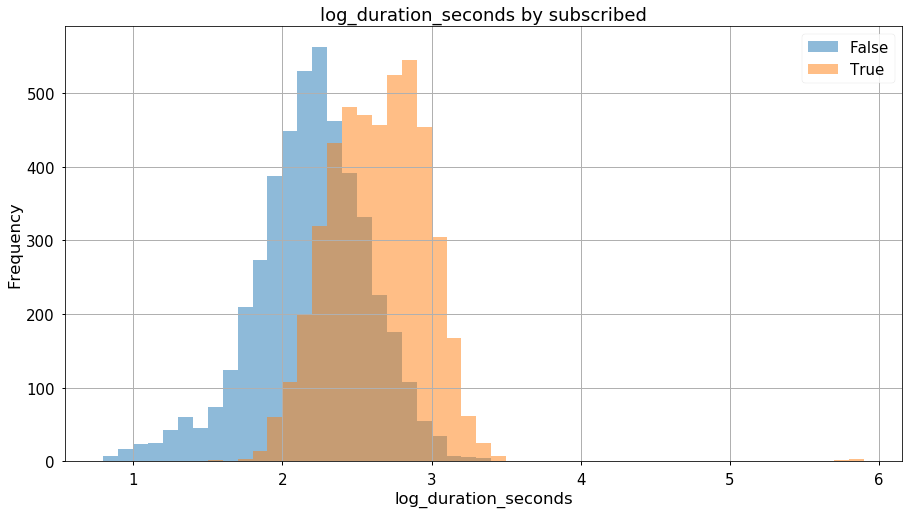

In [15]:
df['log_duration_seconds'] = np.log10(df['duration_seconds'])

min_log_duration_seconds = 0.8
max_log_duration_seconds = 6
print(f'min = {10**min_log_duration_seconds:.1f}s')
print(f'max = {10**max_log_duration_seconds:.0f}s')

multiple_histograms_plot(df, x='log_duration_seconds', hue='subscribed',
                         bins=np.arange(min_log_duration_seconds, 
                                        max_log_duration_seconds, 
                                        0.1))

### emp.var.rate

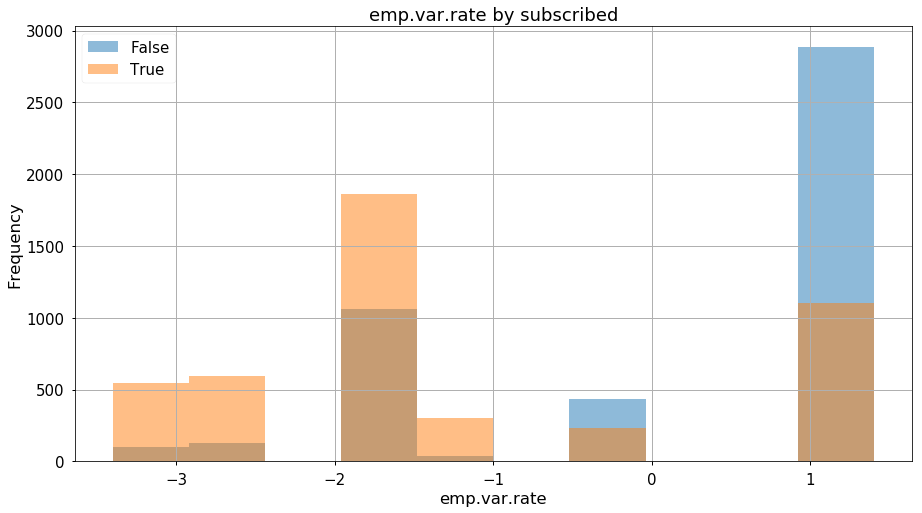

In [16]:
multiple_histograms_plot(df, x='emp.var.rate', hue='subscribed')

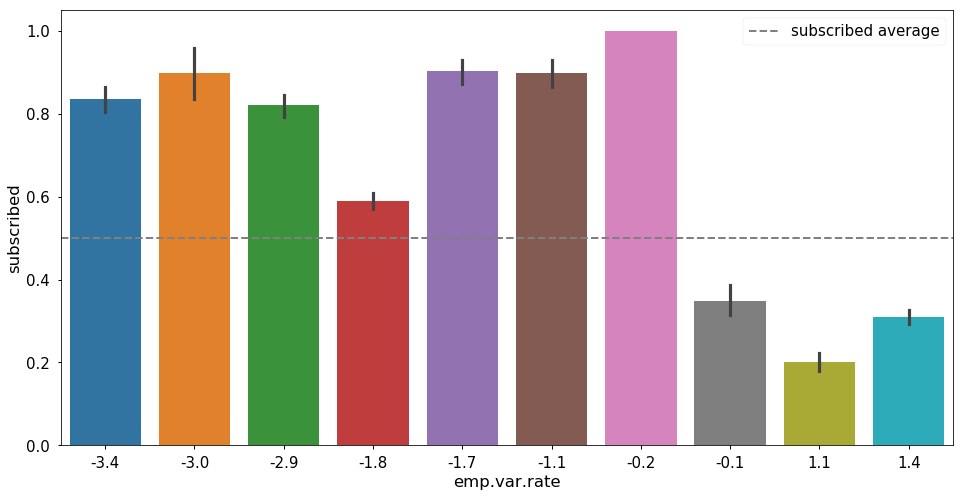

In [17]:
bar_plot_with_categorical(df, 'emp.var.rate', hue='subscribed',
                          order=np.sort(df['emp.var.rate'].unique()))

### month

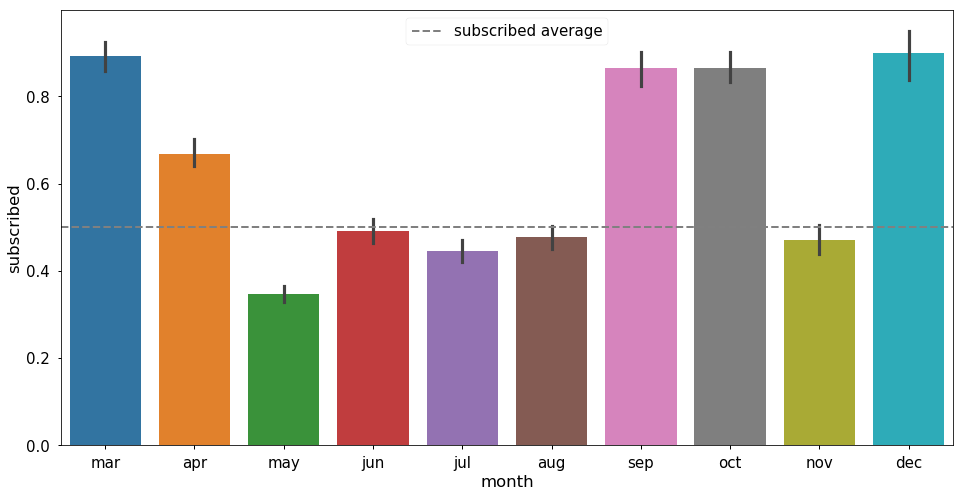

In [18]:
bar_plot_with_categorical(df, 'month', hue='subscribed',
                          order=['mar', 'apr', 'may', 'jun', 'jul', 
                                 'aug', 'sep', 'oct', 'nov', 'dec'])

### nr.employed

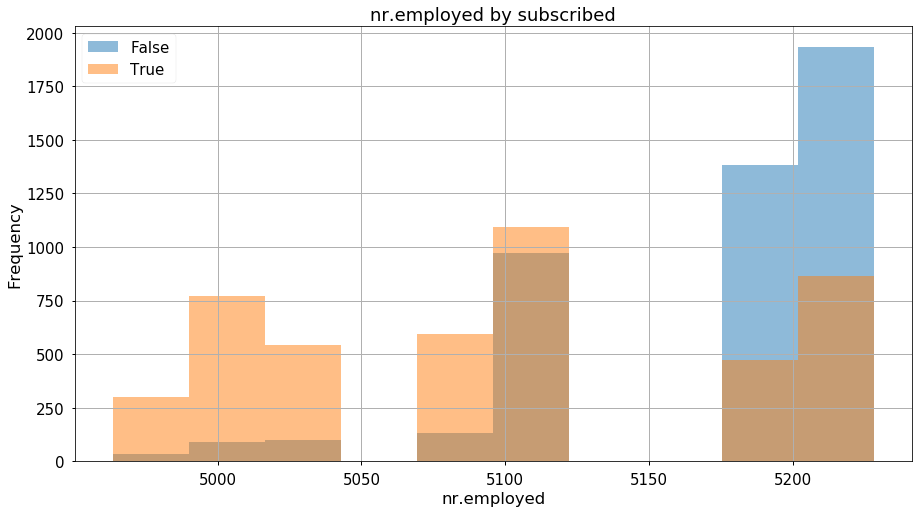

In [19]:
multiple_histograms_plot(df, x='nr.employed', hue='subscribed')

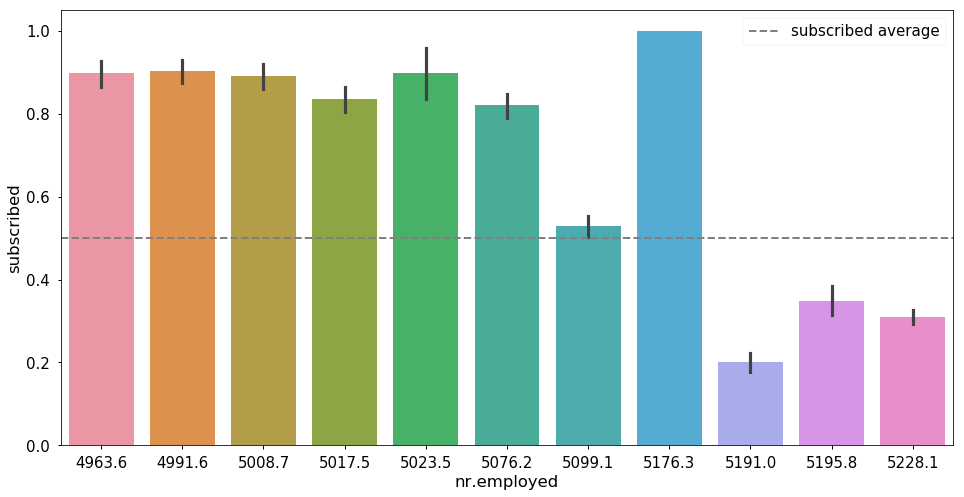

In [20]:
bar_plot_with_categorical(df, 'nr.employed', hue='subscribed',
                          figsize=(16, 8), order=np.sort(df['nr.employed'].unique()))

### euribor3m

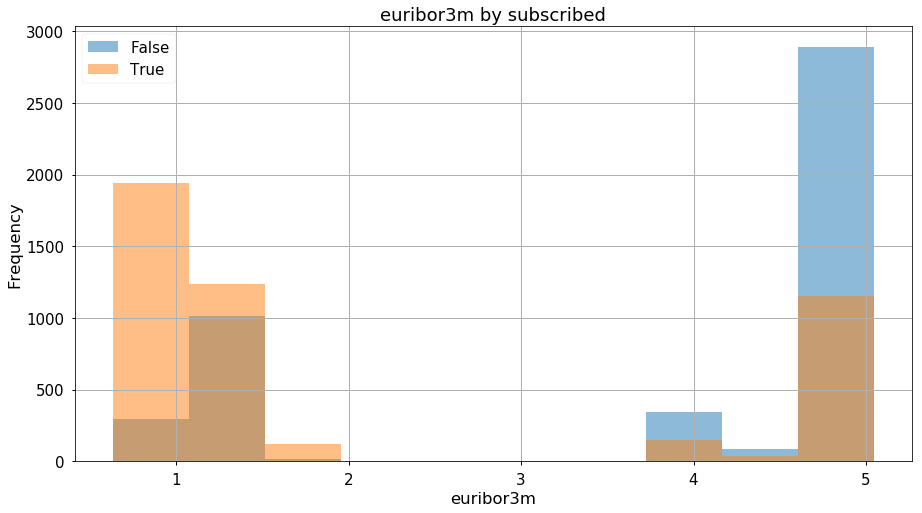

In [21]:
multiple_histograms_plot(df, x='euribor3m', hue='subscribed')

### contact

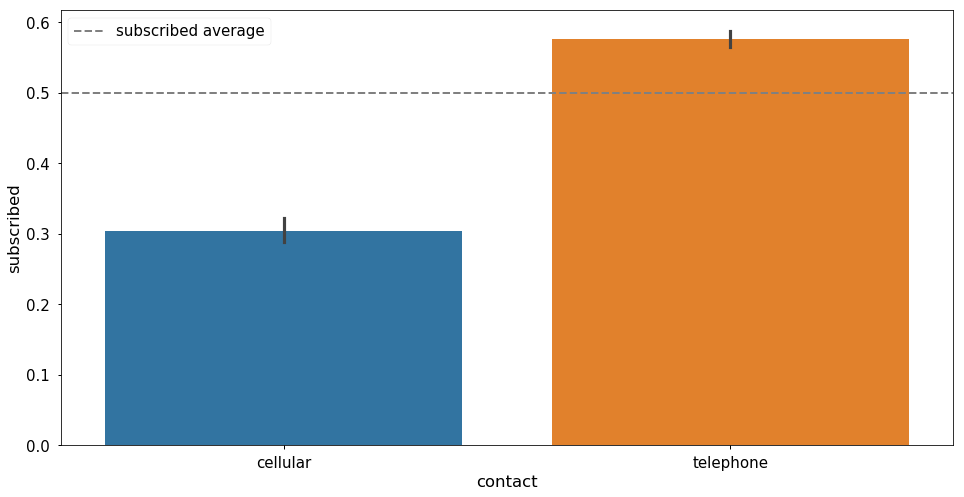

In [22]:
bar_plot_with_categorical(df, 'contact', hue='subscribed',
                          order=[1, 2], xticklabels=['cellular', 'telephone'])

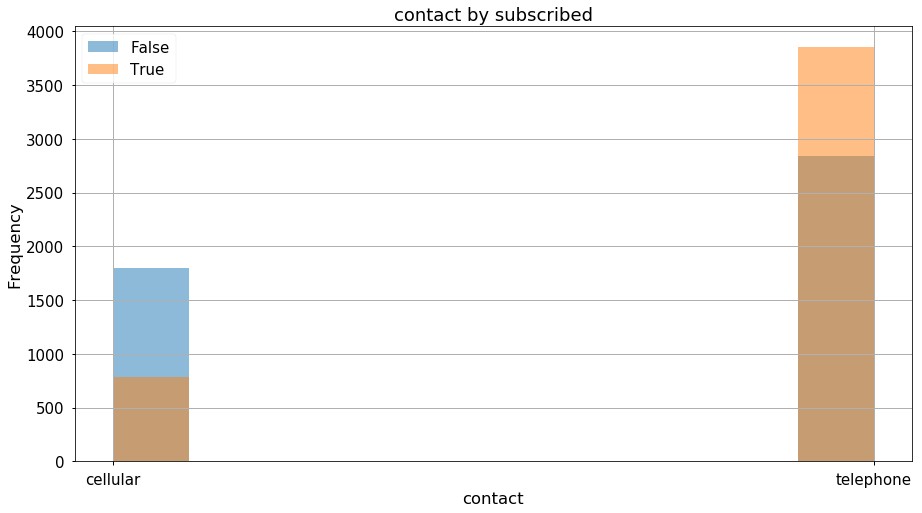

In [23]:
multiple_histograms_plot(df, x='contact', hue='subscribed',
                         xticks=[1, 2], xticklabels=['cellular', 'telephone'])

### loan

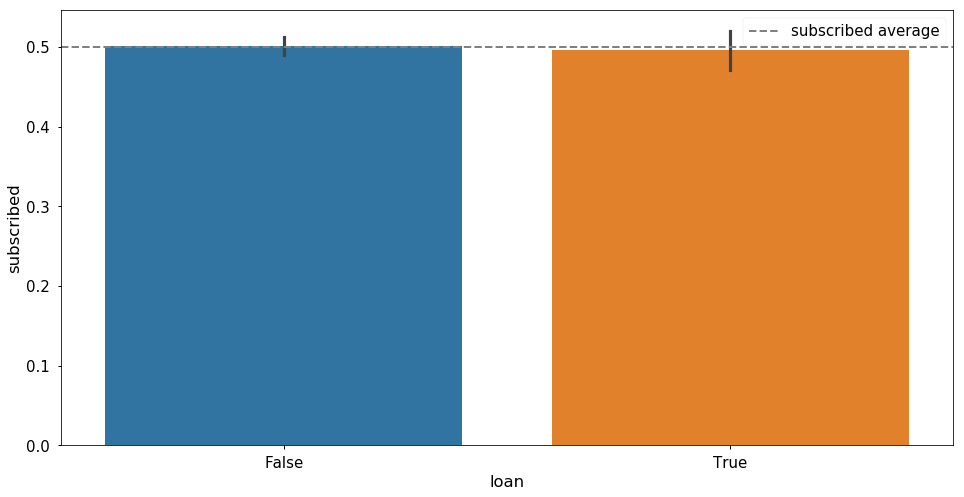

In [24]:
bar_plot_with_categorical(df, 'loan', hue='subscribed',
                          xticklabels=['False', 'True'])

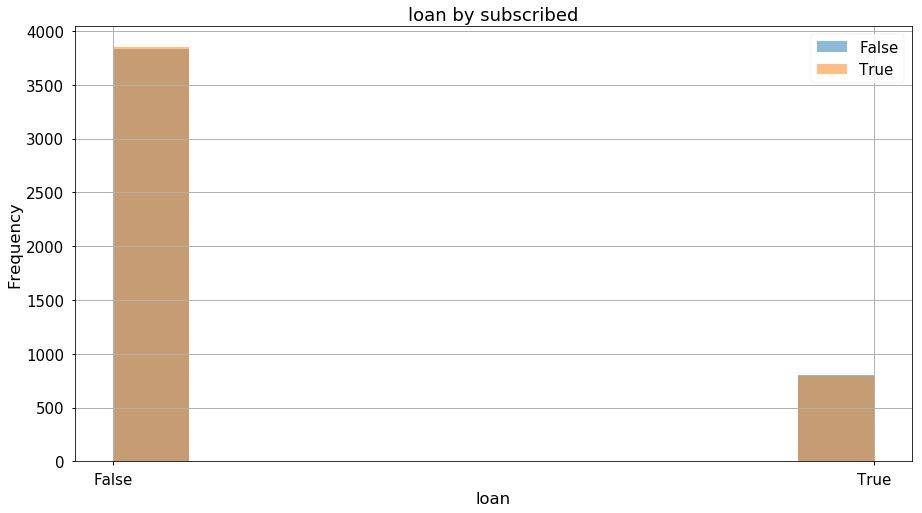

In [25]:
multiple_histograms_plot(df, x='loan', hue='subscribed',
                         xticks=[0, 1], xticklabels=['False', 'True'])

## Preparando os dados

In [26]:
X = df.drop(columns=['log_duration_seconds', 'month', 'subscribed'])
y = df['subscribed']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

## Aplicando a Regressão Logística

In [28]:
logreg = LogisticRegression()

In [29]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [30]:
y_pred[:5]

array([False, False,  True, False,  True], dtype=bool)

In [31]:
accuracy_test = accuracy_score(y_test, y_pred)
print(f'accuracy (test): {accuracy_test*100:.1f}%')

accuracy (test): 83.8%


## Avaliação do modelo

### Matriz de Confusão, Precisão, Recall

In [32]:
confusion_matrix(y_test, y_pred)

array([[735, 180],
       [120, 821]])

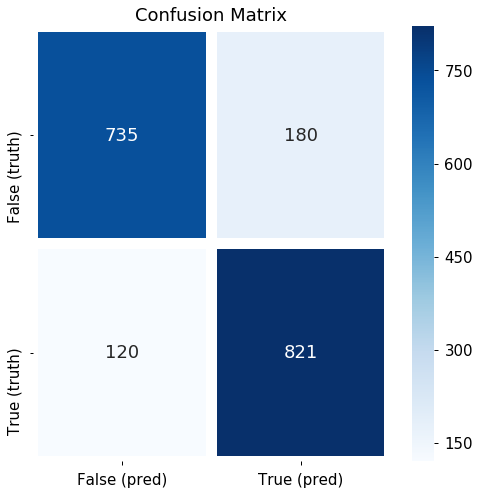

In [33]:
plot_confusion_matrix(y_test, y_pred)

In [34]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.86      0.80      0.83       915
       True       0.82      0.87      0.85       941

avg / total       0.84      0.84      0.84      1856



### Utilizando as probabilidades

In [35]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba[:5]

array([[ 0.52583938,  0.47416062],
       [ 0.83776394,  0.16223606],
       [ 0.07602228,  0.92397772],
       [ 0.97844733,  0.02155267],
       [ 0.06267233,  0.93732767]])

In [36]:
y_pred_proba = y_pred_proba[:, 1]
y_pred_proba[:5]

array([ 0.47416062,  0.16223606,  0.92397772,  0.02155267,  0.93732767])

In [37]:
preds_df = pd.DataFrame(data=[y_pred_proba, y_test.astype(str)],
                        index=['Prediction', 'True Value']).T

preds_df['Prediction'] = preds_df['Prediction'].astype(float)
preds_df['True Value'] = preds_df['True Value'].astype(str)

preds_df.head()

,Prediction,True Value
0,0.474161,False
1,0.162236,False
2,0.923978,True
3,0.021553,False
4,0.937328,True


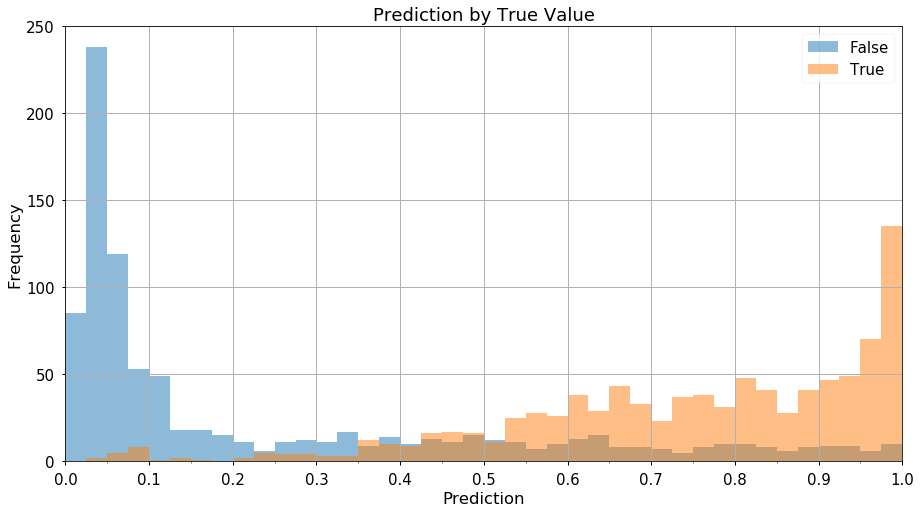

In [38]:
multiple_histograms_plot(data=preds_df, x='Prediction', hue='True Value',
                         bins=np.arange(0, 1.1, 0.025), probability_hist=True)

In [39]:
y_pred_customizado = y_pred_proba >= 0.35

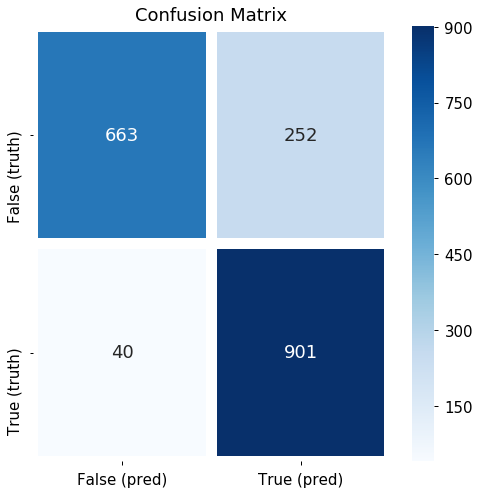

In [40]:
plot_confusion_matrix(y_test, y_pred_customizado)

In [41]:
print(classification_report(y_test, y_pred_customizado))

             precision    recall  f1-score   support

      False       0.94      0.72      0.82       915
       True       0.78      0.96      0.86       941

avg / total       0.86      0.84      0.84      1856



### Outras métricas populares

In [42]:
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (test): 0.9013


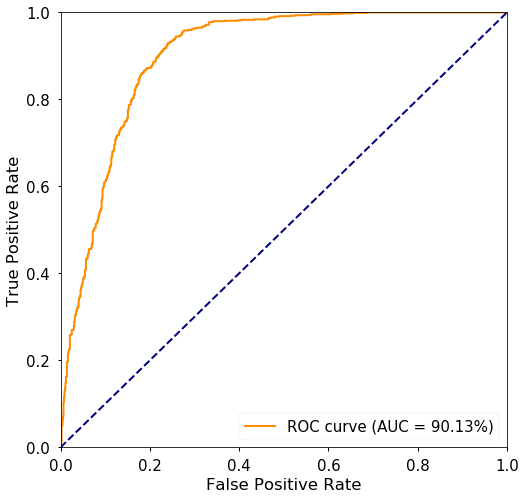

In [43]:
auc_test = plot_roc(y_test, y_pred_proba)

In [44]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.396


### Identificação de overfitting

In [45]:
y_pred_proba_train = logreg.predict_proba(X_train)[:, 1]

In [46]:
print(f'auc (train): {roc_auc_score(y_train, y_pred_proba_train):.4f}')
print(f'auc (test): {roc_auc_score(y_test, y_pred_proba):.4f}')

auc (train): 0.9078
auc (test): 0.9013


## Tentando melhorar o modelo

### One-hot-encoding

In [47]:
pd.get_dummies(df['month']).head()

,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [48]:
df_dummies = pd.concat([df, 
                        pd.get_dummies(df['month'])], 
                       axis='columns')

df_dummies.drop(columns='month', inplace=True)

In [49]:
df_dummies.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,subscribed,log_duration_seconds,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
0,1575,26.250000,0.437500,1.1,5191.0,4.857,1,0,True,3.197281,0,0,0,0,0,0,1,0,0,0
1,1042,17.366667,0.289444,1.1,5191.0,4.857,1,0,True,3.017868,0,0,0,0,0,0,1,0,0,0
2,1467,24.450000,0.407500,1.1,5191.0,4.857,1,0,True,3.166430,0,0,0,0,0,0,1,0,0,0
3,579,9.650000,0.160833,1.1,5191.0,4.857,1,0,True,2.762679,0,0,0,0,0,0,1,0,0,0
4,461,7.683333,0.128056,1.1,5191.0,4.857,1,0,True,2.663701,0,0,0,0,0,0,1,0,0,0


In [50]:
X = df_dummies.drop(columns=['log_duration_seconds', 'subscribed'])
y = df_dummies['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [51]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [52]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.356


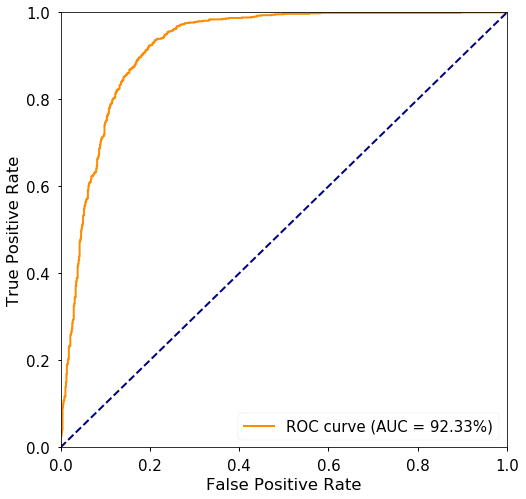

In [53]:
auc_test = plot_roc(y_test, y_pred_proba)

### Tratamento de outliers

In [54]:
df_no_outliers = df_dummies.copy()

In [55]:
outlier_candidates = df_no_outliers['duration_seconds'] > 3000
df_no_outliers[outlier_candidates]

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,subscribed,log_duration_seconds,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
184,618800,10313.333333,166.666667,1.1,5191.0,4.857,1,0,True,5.791550,0,0,0,0,0,0,1,0,0,0
238,726200,12103.333333,166.666667,1.1,5191.0,4.864,1,0,True,5.861056,0,0,0,0,0,0,1,0,0,0
423,636600,10610.000000,166.666667,1.4,5228.1,4.955,1,0,True,5.803867,0,0,0,0,1,0,0,0,0,0
522,728600,12143.333333,166.666667,1.4,5228.1,4.963,2,0,True,5.862489,0,0,0,1,0,0,0,0,0,0
1039,839800,13996.666667,166.666667,1.4,5228.1,4.963,1,0,True,5.924176,0,1,0,0,0,0,0,0,0,0
1407,615200,10253.333333,166.666667,-1.8,5099.1,1.640,2,1,True,5.789016,0,0,0,0,0,1,0,0,0,0


In [56]:
df_no_outliers.loc[outlier_candidates, 'duration_seconds'] = 3000
df_no_outliers.loc[outlier_candidates, 'duration_minutes'] = 3000 / 60
df_no_outliers.loc[outlier_candidates, 'duration_hours'] = 3000 / 60 / 60

In [57]:
df_no_outliers[outlier_candidates]

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,subscribed,log_duration_seconds,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
184,3000,50.0,0.833333,1.1,5191.0,4.857,1,0,True,5.791550,0,0,0,0,0,0,1,0,0,0
238,3000,50.0,0.833333,1.1,5191.0,4.864,1,0,True,5.861056,0,0,0,0,0,0,1,0,0,0
423,3000,50.0,0.833333,1.4,5228.1,4.955,1,0,True,5.803867,0,0,0,0,1,0,0,0,0,0
522,3000,50.0,0.833333,1.4,5228.1,4.963,2,0,True,5.862489,0,0,0,1,0,0,0,0,0,0
1039,3000,50.0,0.833333,1.4,5228.1,4.963,1,0,True,5.924176,0,1,0,0,0,0,0,0,0,0
1407,3000,50.0,0.833333,-1.8,5099.1,1.640,2,1,True,5.789016,0,0,0,0,0,1,0,0,0,0


In [58]:
X = df_no_outliers.drop(columns=['log_duration_seconds', 'subscribed'])
y = df_no_outliers['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [59]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [60]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.355


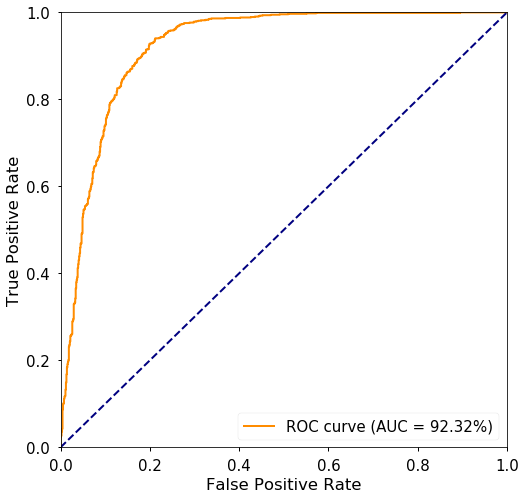

In [61]:
auc_test = plot_roc(y_test, y_pred_proba)

### Padronização (ou standardization) dos dados

In [101]:
df_standardized = df_no_outliers.copy()

In [102]:
X = df_standardized.drop(columns=['log_duration_seconds', 'subscribed'])
y = df_standardized['subscribed']

In [103]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaled_data, 
                        index=X.index,
                        columns=X.columns)

df_standardized = pd.concat([X_scaled, y], axis='columns')

In [104]:
X_scaled.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
0,3.324082,3.324082,3.324082,0.929805,0.641545,1.00536,-1.608036,-0.455229,-0.308616,-0.416528,-0.103842,-0.431738,-0.374044,-0.185592,1.62325,-0.324279,-0.202053,-0.181514
1,1.833208,1.833208,1.833208,0.929805,0.641545,1.00536,-1.608036,-0.455229,-0.308616,-0.416528,-0.103842,-0.431738,-0.374044,-0.185592,1.62325,-0.324279,-0.202053,-0.181514
2,3.021991,3.021991,3.021991,0.929805,0.641545,1.00536,-1.608036,-0.455229,-0.308616,-0.416528,-0.103842,-0.431738,-0.374044,-0.185592,1.62325,-0.324279,-0.202053,-0.181514
3,0.538134,0.538134,0.538134,0.929805,0.641545,1.00536,-1.608036,-0.455229,-0.308616,-0.416528,-0.103842,-0.431738,-0.374044,-0.185592,1.62325,-0.324279,-0.202053,-0.181514
4,0.208071,0.208071,0.208071,0.929805,0.641545,1.00536,-1.608036,-0.455229,-0.308616,-0.416528,-0.103842,-0.431738,-0.374044,-0.185592,1.62325,-0.324279,-0.202053,-0.181514


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=0)

In [67]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [68]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.340


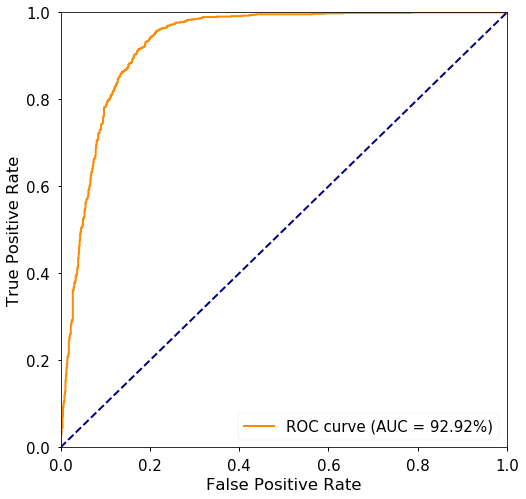

In [69]:
auc_test = plot_roc(y_test, y_pred_proba)

### Seleção de features

In [70]:
selector = RFECV(logreg, step=1, scoring='roc_auc', n_jobs=-1)

In [71]:
_ = selector.fit(X_train, y_train)

In [72]:
pd.DataFrame(data=selector.support_,
             columns=['support'],
             index=X.columns).T

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
support,True,True,True,True,True,True,False,False,False,True,False,True,True,True,True,False,True,False


In [73]:
pd.DataFrame(data=selector.ranking_,
             columns=['support'],
             index=X.columns).T

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,contact,loan,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
support,1,1,1,1,1,1,3,6,2,1,7,1,1,1,1,4,1,5


In [74]:
df_selection = selector.transform(X_train)
df_selection.shape

(7424, 12)

In [75]:
y_pred_proba = selector.predict_proba(X_test)[:, 1]

In [76]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.342


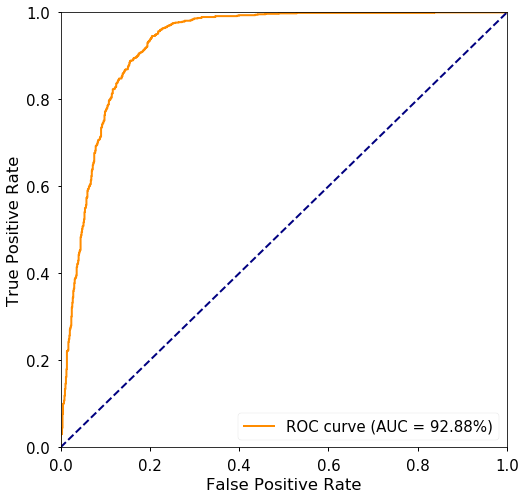

In [77]:
auc_test = plot_roc(y_test, y_pred_proba)

### Regularização com cross-validation

In [95]:
logreg = LogisticRegressionCV(scoring='roc_auc')

In [96]:
logreg.fit(X_train, y_train)
logreg.C_

array([ 166.81005372])

In [97]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [98]:
print(f'log loss (test): {log_loss(y_test, y_pred_proba):.3f}')

log loss (test): 0.340


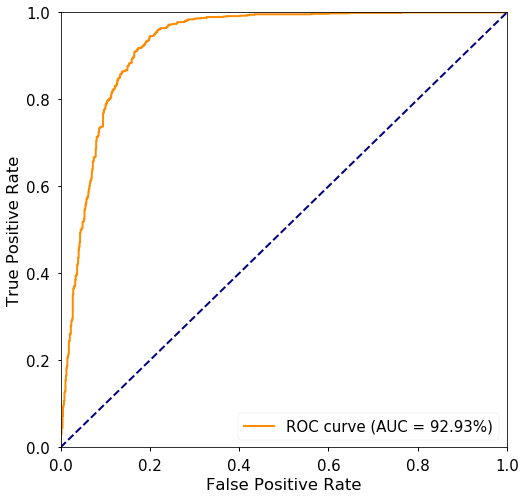

In [99]:
auc_test = plot_roc(y_test, y_pred_proba)

## Salvando o modelo

Vamos salvar o modelo para conseguirmos carregá-lo em análises futuras pós-aula.
Para detalhes, veja a documentação do scikit-learn: [Model Persistence](http://scikit-learn.org/stable/modules/model_persistence.html).

In [83]:
_ = joblib.dump(logreg, '../models/logreg.pkl') 

Vamos também salvar o dataset transformado, assim como foi utilizado pelo modelo final. Para facilitar a interpretação do modelo, salvaremos também uma versão para "display", que é sua versão antes da padronização dos dados.

In [93]:
df_standardized.to_csv('../data/bank_marketing_processed.csv', index=False)

In [106]:
(df_no_outliers.drop(columns='log_duration_seconds')
               .to_csv('../data/bank_marketing_display.csv', index=False))